In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
import json

with open('county_to_lat_long.json', 'r') as f:
    county_lookup = json.load(f)

In [10]:
county_lookup['CA']['Placer']

[39.062032, -120.722718]

In [143]:
def scrape_data(limit=1, states=county_lookup.keys(), 
                years = ['2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011'],
               verbose=False):
    
    import datetime as dt
    from time import sleep
    
    limit=limit
    if limit>4999:
        print('Limit too high!')
        return list(), dict()
    counter = 1 #counter to determine when to exit loop
    
    # initialize outputs
    df = pd.DataFrame()
    error_dict = dict()
        
    # constants in request url
    leap_year = 'false'
    interval = '60'
    utc = 'false'
    your_name = 'John+Lassetter'
    your_email = 'johnllassetter@gmail.com'
    mailing_list = 'true'
    your_affiliation = 'none'
    reason_for_use = 'personal+project'
    api_key = '49SDnsqasChDggnChiFcInyhR1VTRmLfGnCoIn8s'
    attributes = 'ghi,air_temperature'
    
    # this is for a url that can accept multiple years
#     #translate list of years to str of form 'y1,y2,...,yN'
#     year = ''
#     for i in years:
#         year += (i+',')
#     year = year[:-1]    
    
    for state in states:
        for county in county_lookup[state].keys():
            for year in years:
                lat, lon = county_lookup[state][county]

                url = "https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?wkt=POINT({lon}%20{lat})&names={year}&leap_day={leap}&interval={interval}&utc={utc}&full_name={name}&email={email}&affiliation={affiliation}&mailing_list={mailing_list}&reason={reason}&api_key={api}&attributes={attr}".format(
                    year=year, lat=lat, lon=lon, leap=leap_year, interval=interval, utc=utc, name=your_name, 
                    email=your_email, mailing_list=mailing_list, affiliation=your_affiliation,
                    reason=reason_for_use, api=api_key, attr=attributes)
                try:
                    # read data from url
                    df_to_append = pd.read_csv(url, skiprows=2)
                    
                    # add location data
                    df_to_append['state'] = state
                    df_to_append['county'] = county
                    df_to_append['latitude'] = lat
                    df_to_append['longitude'] = lon
                    
                    # condense time information into date column and drop redundant columns
                    df_to_append['date'] = df_to_append.Year.astype(str) + '-' + df_to_append.Month.astype(str).apply(lambda x: '0'+ x if len(x)==1 else x) \
                    + '-' + df_to_append.Day.astype(str).apply(lambda x: '0'+ x if len(x)==1 else x) + ' ' + \
                    df_to_append.Hour.astype(str).apply(lambda x: '0'+ x if len(x)==1 else x) + ':30:00'

                    df_to_append.date = pd.to_datetime(df_to_append.date, infer_datetime_format=True)
                    df_to_append.drop(['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)
                    
                    # rename columns
                    df_to_append.rename({'GHI':'ghi', 'Temperature':'temperature'}, axis=1, inplace=True)
                    
                    #append to dataframe
                    df = df.append(df_to_append, ignore_index=True)
                    
                    if verbose:
                        print('Downloaded {} county in {}.'.format(county, year))
                except:
                    error_dict[county] = (lat, lon)
                    print('Couldnt append: {}, {} county at ({}, {})'.format(year, county, lat, lon))

                # stop getting data after limit number of tries
                counter += 1
                if counter > limit:
                    print('hit limit: {}'.format(limit))
                    return df, error_dict
                
                # save a checkpoint every 30 iterations
                if counter%30==29:
                    checkpoint_path = 'sdc_' + (
                    dt.datetime.now().strftime('%m-%d-%Y-%H-%M-%S') + '.csv')

                    df.to_csv(checkpoint_path, index=True, header=True)
                    print('Saved Checkpoint: {}'.format(checkpoint_path))
                
                sleep(2)
    
    # save data at the end and print path to file
    checkpoint_path = 'sdc_complete_' + (
    dt.datetime.now().strftime('%m-%d-%Y-%H-%M-%S') + '.csv')

    df.to_csv(checkpoint_path, index=True, header=True)
    print('Saved Final DF: {}'.format(checkpoint_path))
                
    return df, error_dict

In [158]:
len(county_lookup['OR'])

36

In [223]:
# df, error_dict = scrape_data(limit=38, states=['OR'], years=['2020'], verbose=True)
print('errors:',list(error_dict.items()))
print(df.shape)
print(df.dtypes)
df.head()
df.columns

In [160]:
df.head()

,ghi,temperature,state,county,latitude,longitude,date
0,0,0.4,OR,Baker,44.703427,-117.691933,2020-01-01 00:30:00
1,0,0.6,OR,Baker,44.703427,-117.691933,2020-01-01 01:30:00
2,0,0.8,OR,Baker,44.703427,-117.691933,2020-01-01 02:30:00
3,0,1.1,OR,Baker,44.703427,-117.691933,2020-01-01 03:30:00
4,0,1.2,OR,Baker,44.703427,-117.691933,2020-01-01 04:30:00


# Put data in SQLite Database

In [177]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/solar_panel.db', echo=False)

In [148]:
# from sqlalchemy import Table, Column, Integer, String, MetaData, Float, Date
# meta = MetaData()

# my_table = Table(
#     'my_table', meta, 
#     Column('id', Integer, primary_key = True),
#     Column('ghi', Integer), 
#     Column('temperature', Float), 
#     Column('state',String),
#     Column('county',String),
#     Column('latitude',Float),
#     Column('longitude',Float),
#     Column('date', Date)
# )

In [162]:
# df.to_sql('my_table', con=engine, if_exists='append')

In [164]:
engine.execute("SELECT * FROM my_table where county='Lane' limit 5").fetchall()

[(166440, 0, 8.5, 'OR', 'Lane', 43.928276, -122.897678, '2020-01-01 00:30:00.000000'),
 (166441, 0, 8.9, 'OR', 'Lane', 43.928276, -122.897678, '2020-01-01 01:30:00.000000'),
 (166442, 0, 9.3, 'OR', 'Lane', 43.928276, -122.897678, '2020-01-01 02:30:00.000000'),
 (166443, 0, 9.6, 'OR', 'Lane', 43.928276, -122.897678, '2020-01-01 03:30:00.000000'),
 (166444, 0, 9.6, 'OR', 'Lane', 43.928276, -122.897678, '2020-01-01 04:30:00.000000')]

In [175]:
df_raw = pd.read_sql(
    "SELECT * FROM my_table",
    con=engine, index_col='index'
)

df_raw.head()


,ghi,temperature,state,county,latitude,longitude,date
index,,,,,,,
0,0,2.4,WA,Adams,47.00484,-118.533308,2020-01-01 00:00:00.000000
1,0,2.6,WA,Adams,47.00484,-118.533308,2020-01-01 01:00:00.000000
2,0,2.8,WA,Adams,47.00484,-118.533308,2020-01-01 02:00:00.000000
3,0,3.0,WA,Adams,47.00484,-118.533308,2020-01-01 03:00:00.000000
4,0,3.0,WA,Adams,47.00484,-118.533308,2020-01-01 04:00:00.000000


In [176]:
df_raw.shape

(1165080, 7)

In [167]:
def η_pv(T_pv, η_max=0.18, loss_per_degree=0.0032):
    # pv efficiency for different pv temperatures
    # https://www.firstsolar.com/-/media/First-Solar/Technical-Documents/Series-6-Datasheets/Series-6-Datasheet.ashx
    η = np.array(η_max - loss_per_degree*(T_pv-25))
    η = np.where(η>η_max, η_max, η)
    return np.where(η<0, 0, η)

def process_raw_data(df):
    
    df_processed = df.copy()
    df_processed.date = pd.to_datetime(df_processed.date)
    df_processed['efficiency'] = df_processed.temperature.apply(η_pv)
    df_processed['solar_power_per_sq_m'] = df_processed.ghi * df_processed.efficiency
    df_processed['year'] = df_processed.date.dt.year
    df_processed['month'] = df_processed.date.dt.month
    df_processed['week'] = df_processed.date.dt.isocalendar().week
    df_processed['day'] = df_processed.date.dt.day
    
    df_processed = df_processed.groupby(['state', 'county', 'year', 'month', 'week', 'day'], as_index=False).agg('mean')    
    
    return df_processed

df_processed = process_raw_data(df_raw)
df_processed.head()

,state,county,year,month,week,day,ghi,temperature,latitude,longitude,efficiency,solar_power_per_sq_m
0,OR,Baker,2020,1,1,1,57.250000,1.629167,44.703427,-117.691933,0.18,10.3050
1,OR,Baker,2020,1,1,2,67.041667,-0.770833,44.703427,-117.691933,0.18,12.0675
2,OR,Baker,2020,1,1,3,43.333333,-1.045833,44.703427,-117.691933,0.18,7.8000
3,OR,Baker,2020,1,1,4,77.666667,-0.854167,44.703427,-117.691933,0.18,13.9800
4,OR,Baker,2020,1,1,5,64.583333,-2.391667,44.703427,-117.691933,0.18,11.6250


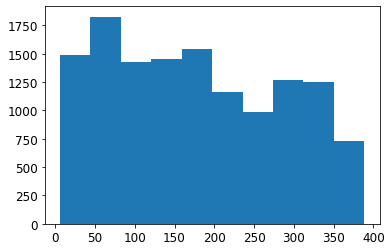

In [168]:
plt.hist(df_processed.ghi);

In [138]:
from sqlalchemy import Table, Column, Integer, String, MetaData, Float, Date
meta = MetaData()

processed_data = Table(
    'processed_solar_data', meta, 
    Column('id', Integer, primary_key = True),
    Column('state',String),
    Column('county',String),
    Column('year',Integer),
    Column('month',Integer),
    Column('week',Integer),
    Column('day',Integer),
    Column('ghi', Float), 
    Column('temperature', Float), 
    Column('latitude',Float),
    Column('longitude',Float),
    Column('efficiency', Float),
    Column('solar_power_per_sq_m', Float)
)

In [169]:
df_processed.to_sql('processed_solar_data', con=engine, if_exists='append')

In [157]:
print(df_processed.shape)

(35405, 12)


Annual Energy Produced: 393719851 (kWh/month)
Expected: 231264 kWh/month


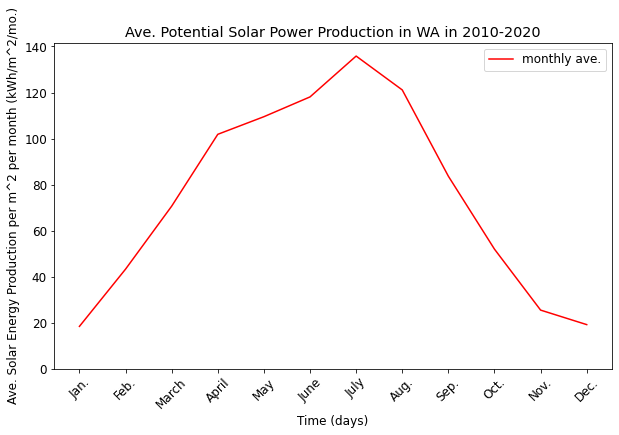

In [137]:
# plot data automatically grouping at different scopes
calibration = 1000
state = 'WA'
county = None

grain = ['month', 'week']

if county:
    mask = (df_processed.county==county)
elif state:
    mask = (df_processed.state==state)

plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 12})

# if county:
y = df_processed[mask].groupby(grain).agg('mean').solar_power_per_sq_m #*60*60/1000
x = range(len(y))
y2 = df_processed[mask].groupby(['month']).agg('mean').solar_power_per_sq_m*60*60*24*30.4/1000/calibration
x2 = np.linspace(min(x), max(x), 12)
    
# plt.plot(x,y, label='weekly ave');
if len(grain)>1:
    plt.plot(x2, y2, c='r', label='monthly ave.');
plt.ylim((0,plt.ylim()[1]))
plt.xlabel('Time (days)')
plt.ylabel('Ave. Solar Energy Production per m^2 per month (kWh/m^2/mo.)')
if county:
    plt.title('Ave. Potential Solar Power Production in {} County, {} in 2010-2020'.format(county, state))
elif state:
    plt.title('Ave. Potential Solar Power Production in {} in 2010-2020'.format(state))
plt.xticks(ticks=np.linspace(min(x), max(x), 12), labels=['Jan.', 'Feb.', 'March', 'April', 'May', 'June', 'July', 'Aug.', 'Sep.', 'Oct.', 'Nov.', 'Dec.'], rotation=45);
plt.legend();
# plt.tight_layout();
# plt.savefig('solar_power_benton_ex.jpg', dpi=300);
print("Annual Energy Produced: {:.0f} (kWh/month)".format(np.mean(y2)*60*60*24*365*2/12))
print('Expected: {:.0f} kWh/month'.format((440/5000)*60*60*24*365/12))

# Put processed data into its own database

In [216]:
from sqlalchemy import Table, Column, Integer, String, MetaData, Float, Date
meta = MetaData()

processed_data = Table(
    'processed_solar_data', meta, 
    Column('id', Integer, primary_key = True),
    Column('state',String),
    Column('county',String),
    Column('year',Integer),
    Column('month',Integer),
    Column('week',Integer),
    Column('day',Integer),
    Column('ghi', Float), 
    Column('temperature', Float), 
    Column('latitude',Float),
    Column('longitude',Float),
    Column('efficiency', Float),
    Column('solar_power_per_sq_m', Float)
)

In [217]:
df_all_processed.to_sql('processed_solar_data', con=engine2, if_exists='fail')

In [222]:
test = pd.read_sql(
    "SELECT * FROM processed_solar_data",
    con=engine2, index_col='index'
)

test.head()

,state,county,year,month,week,day,ghi,temperature,latitude,longitude,efficiency,solar_power_per_sq_m
index,,,,,,,,,,,,
0,CA,Alameda,2020,1,1,1,78.708333,9.366667,37.648081,-121.913304,0.18,14.1675
1,CA,Alameda,2020,1,1,2,118.500000,9.837500,37.648081,-121.913304,0.18,21.3300
2,CA,Alameda,2020,1,1,3,115.291667,9.391667,37.648081,-121.913304,0.18,20.7525
3,CA,Alameda,2020,1,1,4,74.916667,8.820833,37.648081,-121.913304,0.18,13.4850
4,CA,Alameda,2020,1,1,5,126.291667,7.245833,37.648081,-121.913304,0.18,22.7325
